# Meandering channel morphometric analysis

This code computes sinuous channel geomorphic parameters including meander wavelength, amplitude, and sinuosity, according to Leopold and Wolman (1957) methodology (see also Sylvester and Pirmez, 2017; Lemay et al., 2020).

### author:
Martin LEMAY
martin.lemay@mines-paris.org

### Related publication

If you use this script, please refer to the following publication:
- Lemay, M., Grimaud, J. L., Cojan, I., Rivoirard, J., & Ors, F. (2020). Geomorphic variability of submarine channelized systems along continental margins: Comparison with fluvial meandering channels. Marine and Petroleum Geology, 115, 104295. https://doi.org/10.1016/j.marpetgeo.2020.104295

*WARNING: results may slightly differ from the related paper because of subsequent modifications of the code.*

### Dependencies
- numpy
- scipy
- matplotlib
- pandas
- shapely

#### Python modules import

In [22]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

parent_dir_path = os.path.dirname(os.getcwd())
package_path = os.path.join(parent_dir_path, "src")
if package_path not in sys.path:
    sys.path.append(package_path)
    
import pybend.algorithms.centerline_process_function as cpf
import pybend.algorithms.plot_functions as plot
import pybend.algorithms.pybend_io as io
from pybend.model.Centerline import Centerline
from pybend.model.Morphometry import Morphometry


#### Computation script

Compute channel geomorphic parameters according to the following methodology (see Lemay et al., 2020):  

1 resample centerline points; 

2 smooth centerline path; 

3 compute and smooth curvatures; 

4 compute inflection and apex points and define bends; 

5 compute bend geometric parameters

#### Input parameters

In [19]:
working_dir = str(os.path.join(os.getcwd(), "data/"))
input_file_name = "centerline_Abreu_et_al_2003.csv" # centerline data file name - .csv file
output_file_name = input_file_name[:-4] + "_morphometry.csv" # morphometry measurements results file name
delimiter = ';' # column delimiter used in the input and output files
flip = False # to flip data if upstream and downstream end are reversed in the input file

# *** Channel centerline analysis parameters ***
smooth_distance = 1000 # [m] smoothing window applied when smoothing centerline path and curvatures (usually around twice channel width)
spacing = 50 # [m] spacing between channel points after resampling
use_fix_nb_points = False
window_curvature_filter = 15
sinuo_thres = 1.05 # minimum sinuosity allowed to define meanders
n = 2.

# channel dimension parameters used to fit computation windows 
width = 200# [m] -99999 / channel width; if -99999, use the default width of 800 m is taken (corresponding to median values of turbidites channels - see Lemay et al., 2020)
depth = 15 # [m] -99999 / channel mean bankfull depth; if -99999, use the default depth of 27 m is taken (corresponding to median values of turbidites channels - see Lemay et al., 2020)


assert width != -99999, "WARNING: no data for the width"
assert depth != -99999, "WARNING: no data for the depth"

# data loading from csv file   
if input_file_name[-3:] != "csv":
    sys.exit("ERROR: file format %s not managed"%(input_file_name[-3:]))
    
X, Y = np.loadtxt(working_dir + input_file_name, delimiter=';', skiprows=1, unpack=True)
Z = np.zeros_like(X)

# flip data
if flip:
    X = np.flip(X, 0)
    Y = np.flip(Y, 0)
    Z = np.flip(Z, 0)

data = io.create_dataset_from_xy(X, Y)

# centerline object and meanders definition
#centerline = Centerline(0, data, spacing, smooth_distance, lag, nb, sinuo_thres)
centerline = Centerline(
                0,
                data,
                spacing,
                smooth_distance,
                use_fix_nb_points,
                window_curvature_filter,
                sinuo_thres,
                n,
                compute_curvature=True,
                interpol_props=True,
                find_bends=True,
            )
            
print("Centerline loaded")
print(f"Number of bends: {centerline.get_nb_bends()}")

/tmp/ipykernel_541745/2690492081.py:17: DeprecationWarning: Use load_centerline_dataset_from_csv instead.
  data = io.create_dataset_from_xy(X, Y)
2025-03-07 14:58:19,683 - pyBenD - INFO - Initialize Centerline object 0
2025-03-07 14:58:19,683 - pyBenD - INFO - Resample points of centerline 0
2025-03-07 14:58:19,685 - pyBenD - INFO - Smooth centerline 0 path
2025-03-07 14:58:19,885 - pyBenD - INFO - Interpolate properties to new points (centerline 0)
2025-03-07 14:58:21,121 - pyBenD - INFO - Compute channel point curvature (centerline 0)
2025-03-07 14:58:21,265 - pyBenD - INFO - Centerline object 0 initialized
2025-03-07 14:58:21,266 - pyBenD - INFO - Find bends
2025-03-07 14:58:21,272 - pyBenD - INFO - Bends found


Centerline loaded
Number of bends: 28


In [8]:
age, dataset = io.load_centerline_dataset_from_Flumy_csv(working_dir + input_file_name)
X, Y = dataset["Cart_abscissa"].to_numpy(), dataset["Cart_ordinate"].to_numpy()

# flip data
if flip:
    X = np.flip(X, 0)
    Y = np.flip(Y, 0)
    Z = np.flip(Z, 0)

data = io.create_dataset_from_xy(X, Y)

# centerline object and meanders definition
centerline = Centerline(
                0,
                data,
                spacing,
                smooth_distance,
                use_fix_nb_points,
                window_curvature_filter,
                sinuo_thres,
                n,
                compute_curvature=True,
                interpol_props=True,
                find_bends=True,
            )
            
print("Centerline loaded")
print(f"Number of bends: {centerline.get_nb_bends()}")

AssertionError: Cart_abscissa property is missing. Try to use load_dataset_from_csv loader instead.

#### Plot results

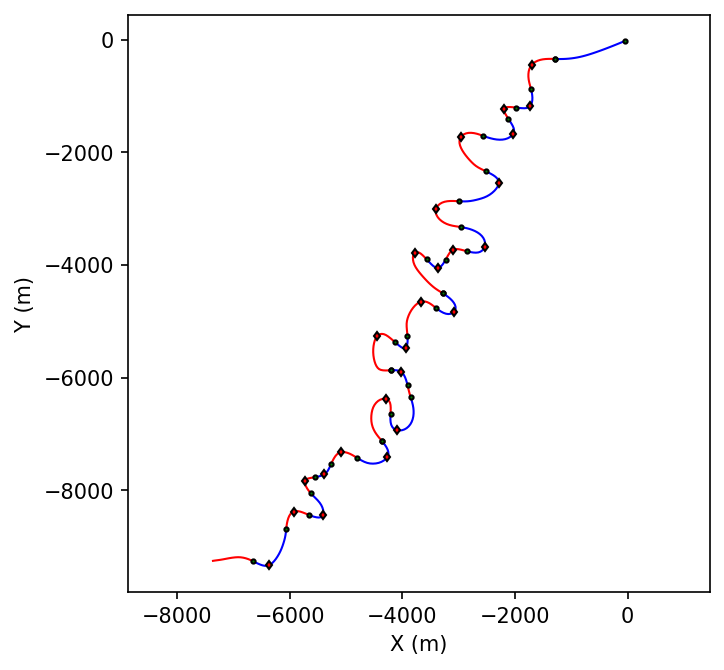

In [20]:
domain=[[],[]]          # plotting area ((xmin, xmax), (ymin, ymax)) - use default pyplot values if the lists are empty 
plot_apex = True        # plot apex points
plot_inflex = True      # plot inflection points
plot_middle = False     # plot middle of inflection points
plot_centroid = False   # plot the centroid of the bend
plot_normal = False     # plot the normal to the channel at each channel point
scale_normal = 1.       # if plot_normal is True, scaling parameter for arraows

annotate = False     # write bend id
annot_text_size = 10 # annotation text size
color_bend = True    # color bend path in blue and red according to curvature
linewidth = 1        # centerline width
markersize = 2       # apex, inflection, middle point marker size

plot_filename = input_file_name[:-4] + ".png" # to save plot figure

fig, ax = plt.subplots(figsize=(5,5), dpi=150)   
plot.plot_bends(ax, (centerline.cl_points,), centerline.bends, domain = domain, annotate = annotate,
           plot_apex = plot_apex, plot_inflex = plot_inflex, plot_middle = plot_middle,
           plot_centroid = plot_centroid, plot_normal = plot_normal, scale_normal = scale_normal,
           annot_text_size = annot_text_size, color_bend = color_bend, 
           alpha=1, cl_color=False)

if len(domain[0]) > 0:
    plt.xlim(domain[0])
if len(domain[1]) > 0:
    plt.ylim(domain[1])
if len(domain[0])+len(domain[1]) == 0:
    plt.axis('equal')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')

#plt.savefig(working_dir + plot_filename, dpi = 150)
plt.show()

In [21]:
# compute average meander geomorphic parameters according to window_size
factor = 5. # estimated wavelength to width ratio; 5 is the median ratio for turbidites channels - see Lemay et al. (2020)

window_size = factor*width
leopold = True

morpho = Morphometry(centerline)
metrics = morpho.compute_bends_morphometry(False)
sinuo_window = [morpho.compute_bend_sinuosity_moving_window(i, window_size) for i in range(centerline.get_nb_bends())]
metric_averaged = pd.DataFrame(np.full_like(metrics, np.nan), columns=metrics.columns)
for i in range(centerline.get_nb_bends()):
    metric_averaged.loc[i] = morpho.compute_average_metric_window(i, window_size)

print(input_file_name)
print("System-averaged bend geometry")
print(metrics.mean(axis=0))
print()

print("Window-averaged meander geometry")
for bend in centerline.bends:    
    print("  Bend:", bend.id)
    print(f"Sinuosity (Window)       {sinuo_window[bend.id]}")
    print(metric_averaged.loc[bend.id])
    print()

print("Individual bend geometry")
for bend in centerline.bends:    
    print("  Bend:", bend.id)
    print(metrics.loc[bend.id])
    print()

centerline_Abreu_et_al_2003.csv
System-averaged bend geometry
Arc_length            810.030639
Wavelength            508.162043
Sinuosity               1.646432
Amplitude             209.590871
Extension             289.003646
RadiusCurvature       687.109696
Asymmetry              -0.087411
Roundness               1.915818
Wavelength_Leopold    910.913708
Amplitude_Leopold     451.365215
dtype: float64

Window-averaged meander geometry
  Bend: 0
Sinuosity (Window)       1.0096
Arc_length            1303.8557
Wavelength            1291.4580
Sinuosity                1.0096
Amplitude               70.5340
Extension              309.6405
RadiusCurvature       3000.1396
Asymmetry                0.4602
Roundness                2.1840
Wavelength_Leopold          NaN
Amplitude_Leopold           NaN
Name: 0, dtype: float64

  Bend: 1
Sinuosity (Window)       1.1631
Arc_length            1091.5206
Wavelength             984.5572
Sinuosity                1.1535
Amplitude              162.0426
Ex